# Intro
Hello! This rather quick and dirty kernel shows how to get started on segmenting nuclei using a neural network in Keras. 

The architecture used is the so-called [U-Net](https://arxiv.org/abs/1505.04597), which is very common for image segmentation problems such as this. I believe they also have a tendency to work quite well even on small datasets.

Let's get started importing everything we need!

In [1]:
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from scipy import ndimage as ndi

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = '/home/peter/dataset/stage1_train/'
TEST_PATH = '/home/peter/dataset/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

/home/peter/anaconda3/envs/dnn/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [3]:
# train_ids = train_ids[:70]

# Get the data
Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now!

In [4]:
from skimage.draw import circle
import math

# Get and resize train images and masks
X_train = []
Y_train = [] 

print('Getting train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    X_train.append(img)
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    mark = np.zeros(img.shape[:2], dtype=np.float32)
    dt   = np.zeros(img.shape[:2], dtype=np.float32)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = (imread(path + '/masks/' + mask_file)>0).astype(np.float32)
        dt_   = ndi.distance_transform_edt(mask_).astype(np.float32)
        r = max( img.shape[0], img.shape[1] ) * .01
        cY, cX = np.unravel_index(np.argmax(dt_, axis=None), dt_.shape) # find local maximum of edt image
        cY = np.clip(cY, r, img.shape[0]-r)
        cX = np.clip(cX, r, img.shape[1]-r)
        # dt_   = dt_ - np.min(dt_)
        dt_   = dt_ / np.max(dt_) # get a distance transform of an instance
        dt    = np.maximum(dt, dt_)
        rr, cc = circle(cY, cX, r, shape=img.shape[:2])
        mark[rr,cc] = 1
        mask = np.maximum(mask, mask_)
    Y_train.append([mask, mark, dt])

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append(img.shape[:2])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting train images and masks ... 


100%|██████████| 670/670 [09:08<00:00,  1.22it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:00<00:00, 94.39it/s]

Done!


Let's see if things look all right by drawing some random images and their associated masks.

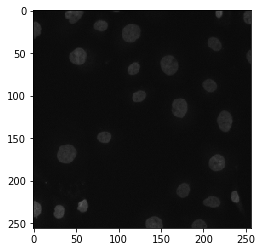

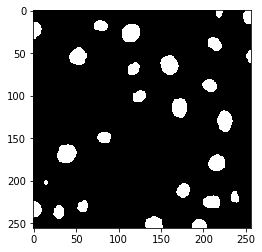

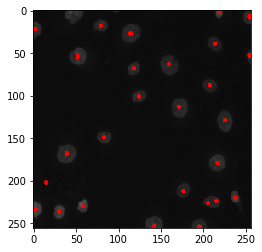

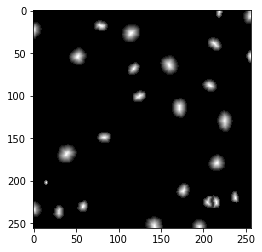

In [5]:
# Check if training data looks all right
ix = np.random.randint(0, len(train_ids))
plt.imshow(X_train[ix])
plt.show()
plt.imshow(np.squeeze(Y_train[ix][0]), cmap='gray')
plt.show()
x_copy = X_train[ix].copy()
x_copy[np.squeeze(Y_train[ix][1])>0, :] = 255, 0, 0
plt.imshow(x_copy)
plt.show()
plt.imshow(np.squeeze(Y_train[ix][2]), cmap='gray')
plt.show()

Seems good!

# Create our Keras metric

Now we try to define the *mean average precision at different intersection over union (IoU) thresholds* metric in Keras. TensorFlow has a mean IoU metric, but it doesn't have any native support for the mean over multiple thresholds, so I tried to implement this. **I'm by no means certain that this implementation is correct, though!** Any assistance in verifying this would be most welcome! 

*Update: This implementation is most definitely not correct due to the very large discrepancy between the results reported here and the LB results. It also seems to just increase over time no matter what when you train ... *

In [6]:
from keras.losses import mean_squared_error
# Define IoU metric
def mean_iou(y_true_, y_pred_):
    y_true = y_true_[...,0]
    y_pred = y_pred_[...,0]
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=None) # scaler

def mean_iou_marker(y_true_, y_pred_):
    y_true = y_true_[...,1]
    y_pred = y_pred_[...,1]
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=None) # scaler

def custom_loss(y_true_, y_pred_):
    
    def dice_coef(y_true, y_pred, intersection): # (batch_size, h, w)
        return (2.*K.sum(intersection) + 1) / (K.sum(y_true) + K.sum(y_pred) + 1) # scaler
    
    def wbce(y_true, y_pred, w):
        return K.sum(K.binary_crossentropy(y_true, y_pred) * w) / (K.sum(w) + K.epsilon())
    
    obj_scale = 5
    noobj_scale = 0.1
    
    y_true_hm = y_true_[...,0] # (batch_size, h, w)
    y_true_mk = y_true_[...,1] # (batch_size, h, w)
    y_true_dt = y_true_[...,2] # (batch_size, h, w)
    
    y_pred_hm = y_pred_[...,0] # (batch_size, h, w)
    y_pred_mk = y_pred_[...,1] # (batch_size, h, w)
    y_pred_dt = y_pred_[...,2] # (batch_size, h, w)
    
    true_mask_scale = y_true_hm * (obj_scale-noobj_scale) + noobj_scale
    s_dt_entropy_loss = wbce(y_true_dt, y_pred_dt, true_mask_scale)
    
    intersection_scale =  (1 - y_true_dt) * y_true_hm + 1
    
    mk_intersection = y_true_mk * y_pred_mk
    hm_intersection = y_true_hm * y_pred_hm
    
    s_marker_dice_coef = dice_coef(y_true_mk * intersection_scale, y_pred_mk * intersection_scale, mk_intersection * intersection_scale) # scaler
    s_heatmap_dice_coef= dice_coef(y_true_hm * intersection_scale, y_pred_hm * intersection_scale, hm_intersection * intersection_scale) # scaler
    
    s_marker_entropy   = wbce(y_true_mk, y_pred_mk, intersection_scale)
    s_heatmap_entropy  = wbce(y_true_hm, y_pred_hm, intersection_scale)
    
    s_marker_loss = s_marker_entropy - K.log(s_marker_dice_coef) # scaler [0, inf)
    s_heatmap_loss= s_heatmap_entropy - K.log(s_heatmap_dice_coef) # scaler [0, inf)
    
    loss = s_marker_loss + s_heatmap_loss + s_dt_entropy_loss # scaler [0, inf)
    loss = tf.Print(loss, [s_marker_dice_coef], message='\nMarker DC:\t', summarize=10)
    loss = tf.Print(loss, [s_marker_entropy], message='\nMarker WBCE:\t', summarize=10)
    loss = tf.Print(loss, [s_heatmap_dice_coef], message='\nHeatmap DC:\t', summarize=10)
    loss = tf.Print(loss, [s_heatmap_entropy], message='\nHeatmap WBCE:\t', summarize=10)
    loss = tf.Print(loss, [s_dt_entropy_loss], message='\nDT WBCE:\t', summarize=10)
    
    return loss # scaler [0, inf)

# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [7]:
from keras.layers import Lambda, Add, Activation, UpSampling2D, Dropout
from keras.optimizers import Adam

def build_stage(inputs, last=None, id_='st1'):
    def conv(f, k=3, act='elu'):
        return Conv2D(f, (k, k), activation=act, kernel_initializer='he_normal', padding='same')
    def _incept_conv(inputs, f, dropout=0, chs=[0.15, 0.5, 0.25, 0.1]):
        fs = [] # determine channel number
        for k in chs:
            t = max(int(k*f), 1) # at least 1 channel
            fs.append(t)
        
        fs[1] += f-np.sum(fs) # reminding channels allocate to 3x3 conv
        
        c1x1 = conv(fs[0], 1, act='linear') (inputs)
        c3x3 = conv(max(1, fs[1]//2), 1, act='elu') (inputs)
        c5x5 = conv(max(1, fs[2]//2), 1, act='elu') (inputs)
        cpool= MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same') (inputs)
        
        c3x3 = conv(fs[1], 3, act='linear') (c3x3)
        c5x5 = conv(fs[2], 5, act='linear') (c5x5)
        cpool= conv(fs[3], 1, act='linear') (cpool)
        
        output = concatenate([c1x1, c3x3, c5x5, cpool], axis=-1)
        if dropout>0:
            output = Dropout(dropout) (output)
        return output
    
    def _res_conv(inputs, f, k=3, dropout=0.1): # very simple residual module
        channels = int(inputs.shape[-1])
        
        cs = _incept_conv(inputs, f, dropout=dropout)
        
        if f!=channels:
            t1 = conv(f, 1, 'linear') (inputs) # identity mapping
        else:
            t1 = inputs
        
        out = Add()([t1, cs]) # t1 + c2
        out = Activation('elu') (out)
        return out
    def pool():
        return MaxPooling2D((2, 2))
    def up(inputs, dropout=0):
        upsampled = Conv2DTranspose(int(inputs.shape[-1]), (2, 2), strides=(2, 2), padding='same') (inputs)
        if dropout>0:
            upsampled = Dropout(dropout) (upsampled)
        return upsampled
    
    if last is None:
        c1 = Lambda(lambda x: x / 255) (inputs) # 1st stage input, an image
    else:
        c1 = concatenate()([inputs, last])
    
    c1 = _res_conv(c1, 32, 3)
    c1 = _res_conv(c1, 32, 3)
    o1 = c1
    p1 = pool() (c1)
    
    c2 = _res_conv(p1, 64, 3)
    c2 = _res_conv(c2, 64, 3)
    p2 = pool() (c2)

    c3 = _res_conv(p2, 128, 3)
    c3 = _res_conv(c3, 128, 3)
    p3 = pool() (c3)
    
    c4 = _res_conv(p3, 256, 3)
    c4 = _res_conv(c4, 256, 3)
    p4 = pool() (c4)
    
    c5 = _res_conv(p4, 512, 3)
    c5 = _res_conv(c5, 512, 3)
    p5 = pool() (c5)
    
    c6 = _res_conv(p5, 512, 3)
    c6 = _res_conv(c6, 512, 3)
    
    u7 = up (c6)
    c7 = concatenate([u7, c5])
    c7 = _res_conv(c7, 512, 3)
    c7 = _res_conv(c7, 512, 3)
    
    u8 = up (c7)
    c8 = concatenate([u8, c4])
    c8 = _res_conv(c8, 256, 3)
    c8 = _res_conv(c8, 256, 3)
    
    u9 = up (c8)
    c9 = concatenate([u9, c3])
    c9 = _res_conv(c9, 128, 3)
    c9 = _res_conv(c9, 128, 3)
    
    u10 = up (c9)
    c10 = concatenate([u10, c2])
    c10 = _res_conv(c10, 64, 3)
    c10 = _res_conv(c10, 64, 3)
    
    u11 = up (c10)
    c11 = concatenate([u11, c1])
    c11 = _res_conv(c11, 32, 3)
    c11 = _res_conv(c11, 32, 3)
    
    outputs = Conv2D(3, (1, 1), activation='sigmoid', name=id_+'_out') (c11)
    return outputs, o1

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
out, _ = build_stage(inputs, None, 'st1')

model = Model(inputs=[inputs], outputs=[out])
model.compile(loss=custom_loss, metrics=[mean_iou, mean_iou_marker], optimizer='adam')
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 8)  32          lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 256, 256, 4)  16          lambda_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [8]:
from keras.utils import Sequence
import cv2
from sklearn.utils import shuffle
from skimage.transform import AffineTransform, warp
import copy

class data_generator(Sequence):
    def __init__(self, data, label, batch_size=4, training=True):
        self.data = data
        self.label= label
        self.batch_size = batch_size
        self.training = training
    def __len__(self):
        return int(np.ceil(float(len(self.data))/self.batch_size))
    def on_epoch_end(self):
        if self.training: self.data, self.label = shuffle(self.data, self.label)
    def __getitem__(self, i):
        l_bound =  i    * self.batch_size
        r_bound = (i+1) * self.batch_size
        if r_bound>len(self.data): # ensure every iteration has the same batch size
            r_bound = len(self.data)
            l_bound = r_bound - self.batch_size
        dat_que = np.empty((self.batch_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
        lab_que = np.empty((self.batch_size, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)
        for n, index in enumerate(range(l_bound, r_bound)):
            img = copy.deepcopy(self.data[index]).astype(np.float32) / 255.
            lab = copy.deepcopy(self.label[index][0])
            marker = copy.deepcopy(self.label[index][1])
            dt = copy.deepcopy(self.label[index][2])
            if self.training:
                if np.random.rand() < .5: # flip vertical
                    img = np.flip(img, 0)
                    lab = np.flip(lab, 0)
                    marker = np.flip(marker, 0)
                    dt = np.flip(dt, 0)
                if np.random.rand() < .5: # flip horizontal
                    img = np.flip(img, 1)
                    lab = np.flip(lab, 1)
                    marker = np.flip(marker, 1)
                    dt = np.flip(dt, 1)

                # rotation, shearing
                if np.random.rand() < 0.5:
                    y, x, _ = img.shape
                    h, w = y, x
                    img = np.pad(img, ((y//2, y//2), (x//2, x//2), (0, 0)), 'reflect')
                    lab = np.pad(lab, ((y//2, y//2), (x//2, x//2)), 'reflect')
                    marker = np.pad(marker, ((y//2, y//2), (x//2, x//2)), 'reflect')
                    dt = np.pad(dt, ((y//2, y//2), (x//2, x//2)), 'reflect')
                    
                    rotT = np.random.uniform(-45,45)
                    shearT = np.random.uniform(-5,5)
                    translationX = np.random.uniform(-w,w) * .1
                    translationY = np.random.uniform(-h,h) * .1
                    atmtx = AffineTransform(rotation=rotT, shear=shearT, translation=(translationX, translationY))

                    img = warp(img, atmtx)
                    lab = warp(lab, atmtx)
                    marker = warp(marker, atmtx)
                    dt = warp(dt, atmtx)

                    img = img[h//2:h//2+h,w//2:w//2+w,:]
                    lab = lab[h//2:h//2+h,w//2:w//2+w]
                    marker = marker[h//2:h//2+h,w//2:w//2+w]
                    dt = dt[h//2:h//2+h,w//2:w//2+w]

                # random amplify each channel
                a = .1 # amptitude
                t  = [np.random.uniform(-a,a)]
                t += [np.random.uniform(-a,a)]
                t += [np.random.uniform(-a,a)]
                t = np.array(t)

                img = np.clip(img * (1. + t), 0, 1) # channel wise amplify
                up = np.random.uniform(0.95, 1.05) # change gamma
                img = np.clip(img**up, 0, 1) # apply gamma and convert back to range [0,255]

            ### end of data augmentation ###

            img = (resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)*255.).astype(np.uint8)
            lab = resize(lab, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            marker = resize(marker, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            dt = resize(dt, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

            dat_que[n,:,:,:] = img
            lab_que[n,:,:,0] = lab > .5
            lab_que[n,:,:,1] = marker > .5
            lab_que[n,:,:,2] = dt
        return dat_que, lab_que

In [ ]:
from sklearn.model_selection import train_test_split
if not os.path.exists('./models'):
    os.makedirs('./models')

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, shuffle=True)

BS=4
EPOCHS=200
train_generator = data_generator(X_train, Y_train, batch_size=BS, training=True)
val_generator = data_generator(X_val, Y_val, batch_size=BS, training=False)

In [ ]:
checkpointer = ModelCheckpoint('./models/model.{epoch:03d}.vl.{val_loss:.2f}.vi.{val_mean_iou:.2f}.vim.{val_mean_iou_marker:.2f}.h5', verbose=0, save_best_only=False)
checkpointer_best = ModelCheckpoint('./models/best.h5', verbose=1, save_best_only=True)
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator), epochs=EPOCHS, 
                              validation_data=val_generator, 
                              validation_steps=len(val_generator),
                              callbacks=[checkpointer, checkpointer_best],
                              workers=5,
                              use_multiprocessing=True
                              )

Epoch 1/200
151/151 [==============================] - 79s 523ms/step - loss: 3.4554 - mean_iou: 0.5531 - mean_iou_marker: 0.5150 - val_loss: 2.3392 - val_mean_iou: 0.6460 - val_mean_iou_marker: 0.5525

Epoch 00001: val_loss improved from inf to 2.33916, saving model to ./models/best.h5
Epoch 2/200
151/151 [==============================] - 72s 479ms/step - loss: 2.3061 - mean_iou: 0.6822 - mean_iou_marker: 0.5684 - val_loss: 2.0410 - val_mean_iou: 0.7090 - val_mean_iou_marker: 0.5831

Epoch 00002: val_loss improved from 2.33916 to 2.04101, saving model to ./models/best.h5
Epoch 3/200
151/151 [==============================] - 73s 483ms/step - loss: 2.0422 - mean_iou: 0.7274 - mean_iou_marker: 0.5926 - val_loss: 1.6764 - val_mean_iou: 0.7441 - val_mean_iou_marker: 0.6010

Epoch 00003: val_loss improved from 2.04101 to 1.67641, saving model to ./models/best.h5
Epoch 4/200
151/151 [==============================] - 73s 483ms/step - loss: 1.7357 - mean_iou: 0.7577 - mean_iou_marker: 0.607


Epoch 00032: val_loss improved from 1.27300 to 1.27223, saving model to ./models/best.h5
Epoch 33/200
151/151 [==============================] - 71s 469ms/step - loss: 1.2932 - mean_iou: 0.8516 - mean_iou_marker: 0.6725 - val_loss: 1.2583 - val_mean_iou: 0.8522 - val_mean_iou_marker: 0.6731

Epoch 00033: val_loss improved from 1.27223 to 1.25829, saving model to ./models/best.h5
Epoch 34/200
151/151 [==============================] - 71s 469ms/step - loss: 1.3441 - mean_iou: 0.8528 - mean_iou_marker: 0.6736 - val_loss: 1.3561 - val_mean_iou: 0.8532 - val_mean_iou_marker: 0.6740

Epoch 00034: val_loss did not improve
Epoch 35/200
151/151 [==============================] - 71s 467ms/step - loss: 1.3098 - mean_iou: 0.8539 - mean_iou_marker: 0.6745 - val_loss: 1.2698 - val_mean_iou: 0.8544 - val_mean_iou_marker: 0.6752

Epoch 00035: val_loss did not improve
Epoch 36/200
151/151 [==============================] - 71s 469ms/step - loss: 1.2870 - mean_iou: 0.8549 - mean_iou_marker: 0.6757 - 

Epoch 65/200
151/151 [==============================] - 69s 459ms/step - loss: 1.5241 - mean_iou: 0.8710 - mean_iou_marker: 0.6923 - val_loss: 1.3068 - val_mean_iou: 0.8710 - val_mean_iou_marker: 0.6924

Epoch 00065: val_loss did not improve
Epoch 66/200
151/151 [==============================] - 70s 465ms/step - loss: 1.2847 - mean_iou: 0.8712 - mean_iou_marker: 0.6925 - val_loss: 1.2291 - val_mean_iou: 0.8714 - val_mean_iou_marker: 0.6927

Epoch 00066: val_loss did not improve
Epoch 67/200
151/151 [==============================] - 70s 463ms/step - loss: 1.3740 - mean_iou: 0.8715 - mean_iou_marker: 0.6929 - val_loss: 1.2396 - val_mean_iou: 0.8716 - val_mean_iou_marker: 0.6930

Epoch 00067: val_loss did not improve
Epoch 68/200
151/151 [==============================] - 70s 465ms/step - loss: 1.3125 - mean_iou: 0.8718 - mean_iou_marker: 0.6932 - val_loss: 1.2406 - val_mean_iou: 0.8720 - val_mean_iou_marker: 0.6933

Epoch 00068: val_loss did not improve
Epoch 69/200
151/151 [==========


Epoch 00097: val_loss did not improve
Epoch 98/200
151/151 [==============================] - 71s 467ms/step - loss: 1.3303 - mean_iou: 0.8808 - mean_iou_marker: 0.7038 - val_loss: 1.3122 - val_mean_iou: 0.8808 - val_mean_iou_marker: 0.7039

Epoch 00098: val_loss did not improve
Epoch 99/200
151/151 [==============================] - 72s 475ms/step - loss: 1.2195 - mean_iou: 0.8809 - mean_iou_marker: 0.7040 - val_loss: 1.2223 - val_mean_iou: 0.8809 - val_mean_iou_marker: 0.7041

Epoch 00099: val_loss did not improve
Epoch 100/200
151/151 [==============================] - 71s 470ms/step - loss: 1.1454 - mean_iou: 0.8810 - mean_iou_marker: 0.7042 - val_loss: 1.1848 - val_mean_iou: 0.8812 - val_mean_iou_marker: 0.7044

Epoch 00100: val_loss did not improve
Epoch 101/200
151/151 [==============================] - 71s 469ms/step - loss: 1.1217 - mean_iou: 0.8813 - mean_iou_marker: 0.7046 - val_loss: 1.1810 - val_mean_iou: 0.8814 - val_mean_iou_marker: 0.7048

Epoch 00101: val_loss did not

In [ ]:
plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.title('model mean_iou')
plt.ylabel('mean_iou')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['mean_iou_marker'])
plt.plot(history.history['val_mean_iou_marker'])
plt.title('model mean_iou_marker')
plt.ylabel('mean_iou_marker')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper right')
plt.show()

All right, looks good! Loss seems to be a bit erratic, though. I'll leave it to you to improve the model architecture and parameters! 

# Make predictions

Let's make predictions both on the test set, the val set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

In [ ]:
from skimage.morphology import closing, square, remove_small_objects
from skimage.segmentation import clear_border
from skimage.filters import threshold_otsu

train_generator = data_generator(X_train, Y_train, batch_size=BS, training=False)
val_generator = data_generator(X_val, Y_val, batch_size=BS, training=False)

# Predict on train, val and test
model = load_model('./models/best.h5', custom_objects={'mean_iou': mean_iou, 'custom_loss': custom_loss, 'mean_iou_marker': mean_iou_marker})
preds_train = model.predict_generator(train_generator, steps=len(train_generator), verbose=1)
preds_val = model.predict_generator(val_generator, steps=len(val_generator), verbose=1)
preds_test = model.predict(X_test, verbose=1, batch_size=BS)

preds_train, preds_train_marker, preds_train_dt = np.transpose(preds_train, (3,0,1,2))
preds_val, preds_val_marker, preds_val_dt = np.transpose(preds_val, (3,0,1,2))
preds_test, preds_test_marker, preds_test_dt = np.transpose(preds_test, (3,0,1,2))

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append((resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True),
                                 resize(np.squeeze(preds_test_marker[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True),
                                 resize(np.squeeze(preds_test_dt[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True)
                                ))

In [ ]:
from skimage.morphology import watershed

# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def lb(image, marker, distance):
    if np.sum(image) < np.sum(marker):
        image = marker
    else:
        marker = np.array((marker==1) & (image==1))
    markers = ndi.label(marker)[0]
    labels = watershed(-distance, markers, mask=image)
    if np.sum(labels) == 0:
        labels[0,0] = 1
    return labels

def prob_to_rles(x, marker, dt):
    x_thres = threshold_otsu(x)
    marker_thres = threshold_otsu(marker)
    lab_img = lb(x > x_thres, marker > marker_thres, dt)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [ ]:
# Perform a sanity check on some random training samples
ix = np.random.randint(0, len(preds_train))
print(ix)
shape = Y_train[ix][0].shape[:2]
hm_otsu_r = resize(np.squeeze(preds_train[ix]), shape)
mk_otsu_r = resize(np.squeeze(preds_train_marker[ix]), shape)
hm_otsu_r = hm_otsu_r > threshold_otsu(hm_otsu_r)
mk_otsu_r = mk_otsu_r > threshold_otsu(mk_otsu_r)
dt_r = resize(np.squeeze(preds_train_dt[ix]), shape)
plt.imshow(X_train[ix])
plt.show()
plt.imshow(np.squeeze(Y_train[ix][0]))
plt.show()
plt.imshow(hm_otsu_r)
plt.show()
plt.imshow(np.squeeze(Y_train[ix][1]))
plt.show()
plt.imshow(mk_otsu_r)
plt.show()
plt.imshow(dt_r)
plt.show()
lab = lb(hm_otsu_r, mk_otsu_r, dt_r)
plt.imshow(lab, cmap=plt.get_cmap('tab20'))
plt.show()

The model is at least able to fit to the training data! Certainly a lot of room for improvement even here, but a decent start. How about the validation data?

In [ ]:
# Perform a sanity check on some random validation samples
ix = np.random.randint(0, len(preds_val))
print(ix)
shape = Y_val[ix][0].shape[:2]
hm_otsu_r = resize(np.squeeze(preds_val[ix]), shape)
mk_otsu_r = resize(np.squeeze(preds_val_marker[ix]), shape)
hm_otsu_r = hm_otsu_r > threshold_otsu(hm_otsu_r)
mk_otsu_r = mk_otsu_r > threshold_otsu(mk_otsu_r)
dt_r = resize(np.squeeze(preds_val_dt[ix]), shape)
plt.imshow(X_val[ix])
plt.show()
plt.imshow(np.squeeze(Y_val[ix][0]))
plt.show()
plt.imshow(hm_otsu_r)
plt.show()
plt.imshow(np.squeeze(Y_val[ix][1]))
plt.show()
plt.imshow(mk_otsu_r)
plt.show()
plt.imshow(dt_r)
plt.show()
lab = lb(hm_otsu_r, mk_otsu_r, dt_r)
plt.imshow(lab, cmap=plt.get_cmap('tab20'))
plt.show()

Not too shabby! Definitely needs some more training and tweaking.

# Encode and submit our results

Now it's time to submit our results. I've stolen [this](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python) excellent implementation of run-length encoding.

Let's iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage ...

In [ ]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(*preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

... and then finally create our submission!

In [ ]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)

This scored 0.233 on the LB for me. That was with version 2 of this notebook; be aware that the results from the neural network are extremely erratic and vary greatly from run to run (version 3 is significantly worse, for example). Version 7 scores 0.277!

You should easily be able to stabilize and improve the results just by changing a few parameters, tweaking the architecture a little bit and training longer with early stopping.

**Have fun!**

LB score history:
- Version 7: 0.277 LB